<a href="https://colab.research.google.com/github/PritishWadhwa/CM-Project/blob/master/Models/squeezenet_octmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from fastai.vision.all import *
from fastai import *
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as transforms
from fastai.data.external import *

In [3]:
data_flag = 'octmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [4]:
DataClass=getattr(medmnist, info['python_class'])

In [5]:
train_dataset= DataClass(split='train',download=download)
val_dataset=DataClass(split='val',download=download)
test_dataset=DataClass(split='test',download=download)

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [6]:
data={'Image':[],"Labels":[],"is_valid":[]}

In [7]:
for i in range(len(train_dataset)):
  data['Image'].append(train_dataset[i][0])
  data['Labels'].append(train_dataset[i][1][0])
  data['is_valid'].append(True)

for i in range(len(val_dataset)):
  data['Image'].append(val_dataset[i][0])
  data['Labels'].append(val_dataset[i][1][0])
  data['is_valid'].append(False)

In [8]:
train_df=pd.DataFrame.from_dict(data)
train_df

,Image,Labels,is_valid
0,<PIL.Image.Image image mode=L size=28x28>,0,True
1,<PIL.Image.Image image mode=L size=28x28>,3,True
2,<PIL.Image.Image image mode=L size=28x28>,3,True
3,<PIL.Image.Image image mode=L size=28x28>,3,True
4,<PIL.Image.Image image mode=L size=28x28>,0,True
...,...,...,...
108304,<PIL.Image.Image image mode=L size=28x28>,0,False
108305,<PIL.Image.Image image mode=L size=28x28>,3,False
108306,<PIL.Image.Image image mode=L size=28x28>,0,False
108307,<PIL.Image.Image image mode=L size=28x28>,0,False


In [9]:
train_df=train_df.sample(frac = 1).reset_index(drop=True)
train_df

,Image,Labels,is_valid
0,<PIL.Image.Image image mode=L size=28x28>,1,True
1,<PIL.Image.Image image mode=L size=28x28>,3,True
2,<PIL.Image.Image image mode=L size=28x28>,3,True
3,<PIL.Image.Image image mode=L size=28x28>,0,True
4,<PIL.Image.Image image mode=L size=28x28>,3,True
...,...,...,...
108304,<PIL.Image.Image image mode=L size=28x28>,1,True
108305,<PIL.Image.Image image mode=L size=28x28>,3,True
108306,<PIL.Image.Image image mode=L size=28x28>,3,True
108307,<PIL.Image.Image image mode=L size=28x28>,1,True


In [10]:
def get_x(r):
    img=r['Image']
    img=np.asarray(img)
    return (img).astype(np.uint8)

def get_y(r):
    return r["Labels"]

In [11]:
switch=True
block=""
if n_channels==1 and switch:
  block=(ImageBlock(cls=PILImageBW), CategoryBlock) 
else:
  block=(ImageBlock(), CategoryBlock)

dblock = DataBlock(
    blocks=block,
    get_x=get_x,
    get_y=get_y,
    splitter=ColSplitter()
)

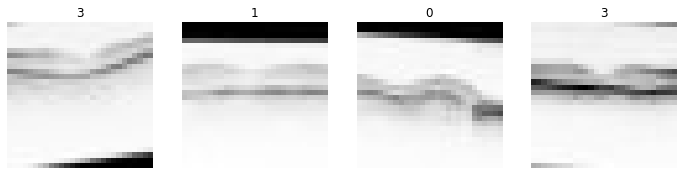

In [12]:
dls = dblock.dataloaders(train_df, bs=32, device=torch.device('cuda'))
dls.show_batch(nrows=1, ncols=4)

In [13]:

learn = vision_learner(dls, squeezenet1_0, metrics=accuracy)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)  

epoch,train_loss,valid_loss,accuracy,time
0,1.225127,4.608551,0.692122,01:54
1,0.954777,2.686575,0.703930,01:52
2,0.862882,1.576486,0.710106,01:51
3,0.856146,1.798560,0.707510,01:51


epoch,train_loss,valid_loss,accuracy,time
0,0.871773,1.139362,0.705879,01:57
1,0.707216,0.727745,0.779733,01:55
2,0.640962,0.727378,0.790792,01:55


In [15]:
learn.metrics = accuracy
learn.validate() #(loss,accuracy)(for validation)

(#2) [0.7273784875869751,0.7907916903495789]

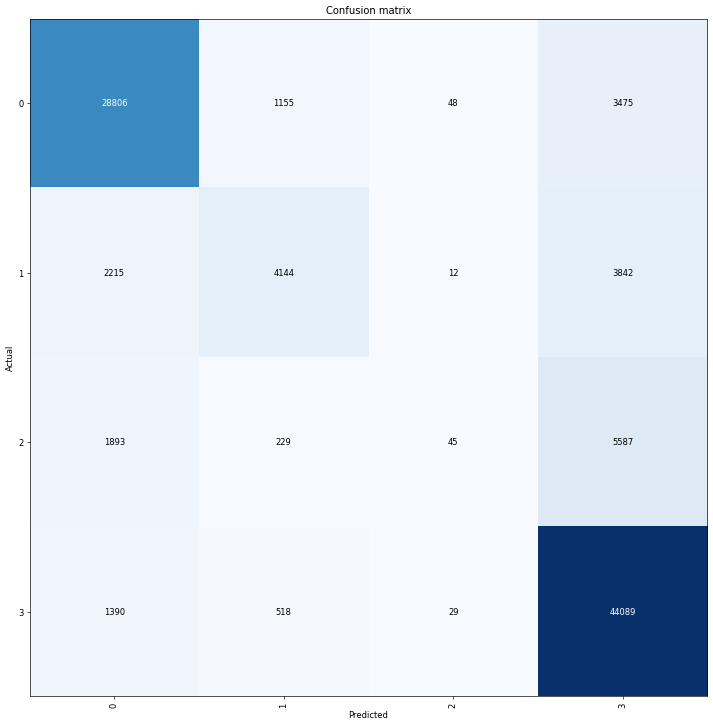

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) # confusion matrix

In [17]:
predictions=[]
labels=[]
for i in range(len(test_dataset)):
  img=np.asarray(test_dataset[i][0])
  img=(img).astype(np.uint8)
  pred,_,probs=learn.predict(img)
  predictions.append(int(pred))
  labels.append(test_dataset[i][1][0])

In [18]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.59      0.91      0.72       250
           1       0.91      0.48      0.62       250
           2       0.00      0.00      0.00       250
           3       0.51      0.98      0.67       250

    accuracy                           0.59      1000
   macro avg       0.50      0.59      0.50      1000
weighted avg       0.50      0.59      0.50      1000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
predictions=[]
labels=[]
for i in tqdm(range(len(test_dataset))):
  img=np.asarray(test_dataset[i][0])
  img=(img).astype(np.uint8)
  pred,_,probs=learn.predict(img)
  predictions.append(int(pred))
  labels.append(test_dataset[i][1][0])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.56      0.88      0.68       250
           1       0.89      0.48      0.62       250
           2       0.50      0.00      0.01       250
           3       0.52      0.97      0.68       250

    accuracy                           0.58      1000
   macro avg       0.62      0.58      0.50      1000
weighted avg       0.62      0.58      0.50      1000



In [ ]:
# resnet18, resnet34, resnet50, resnet101, resnet152
# vgg16_bn, vgg19_bn
# alexnet
# densenet121, densenet169, densenet201, densenet161
# squeezenet1_0, squeezenet1_1

## list of models

In [ ]:
#learner.export(export.pkl)
#learner = load_learner(path=learn.path) #store model

In [ ]:
#learn.lr_find() # to find optimal lr